# Library Visualizations
##### Data visualizations of print books in the University of Edinburgh's library

* **Funding:** Edinburgh Futures Institute (EFI)
* **Data Source:** Library and University Collections (L&UC), OCLC MARC Data for Print Books
* **Project Dates:** 17 June 2019 - 27 July 2019
* **Author:** Lucy Havens

Note: to run this notebook please launch in a terminal window with the following command (the default date rate limit is too small to run the notebook properly): *jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000000000*

## Preparation

Import required libraries

In [1]:
%matplotlib inline
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

## Geographic Visualization

Load file geoJSON files from Natural Earth with the latitude and longitude coordinates for cities, countries and continents.

In [2]:
# From: www.naturalearthdata.com/downloads/ and mapshaper.org

ne_cities = pd.read_json('Data/MapData/ne_50m_populated_places/ne_50m_populated_places.json')
ne_countries = pd.read_json('Data/MapData/ne_50m_admin_0_countries/ne_50m_admin_0_countries.json')
ne_continents = pd.read_json('Data/MapData/ne_50m_physical_labels/ne_50m_geography_regions_polys.json')

From the Natural Earth data, create subsets of the data for:
1. The names and coordinates of every city, and its associated country and continent
2. The names and coordinates of every country, and its associated cities and continent
3. The names and coordinates of every continent, and its associated cities and countries

In [3]:
# INPUT: geoJSON series from mapshaper export of Natural Earth data for populated places
# OUTPUT: dictionary of cities' names, coordinates, and countries
def citiesAndCountries(ne_geojson_series):
    names = []
    coords = []
    countries = []
    for feature in ne_geojson_series.features:
        coords.append(feature['geometry']['coordinates'])
        names.append(feature['properties']['NAME'])
        countries.append(feature['properties']['SOV0NAME'])
    
    assert len(coords) == len(names)
    assert len(countries) == len(names)
    
    return {"name":names,"coordinates":coords,"country":countries}

In [4]:
cities_dict = citiesAndCountries(ne_cities)
df_cities = pd.DataFrame(cities_dict)
df_cities.shape

(1249, 3)

In [5]:
df_cities.head()

,coordinates,country,name
0,"[32.533299524864844, 0.583299105614628]",Uganda,Bombo
1,"[30.27500161597942, 0.671004121125236]",Uganda,Fort Portal
2,"[15.798996495640267, 40.642002130098206]",Italy,Potenza
3,"[14.655996558921856, 41.56299911864397]",Italy,Campobasso
4,"[7.315002595706176, 45.7370010670723]",Italy,Aosta


In [6]:
# INPUT: geoJSON series from mapshaper export of Natural Earth data for countries and 
#        a list of countries from cities dataframe (to include in countries dataframe)
# OUTPUT: dictionary of countries' names, coordinates, and continents
def countriesAndContinents(ne_geojson_series):
    names = []
    names_alt = []
    coords = []
    continents = []
    
    for feature in ne_geojson_series.features:
        if (feature['properties']['TYPE'] == 'Sovereign country'):
            coords.append(feature['geometry']['coordinates'])
            name = feature['properties']['NAME']
            names.append(name)
            others = [feature['properties']['NAME_SORT'], feature['properties']['SOVEREIGNT'], feature['properties']['NAME_LONG']]
            alts = []
            for o in others:
                if (o != name) and (o not in alts):
                    alts.append(o)
            names_alt.append(alts)
            continents.append(feature['properties']['CONTINENT'])
        
    assert len(coords) == len(names)
    assert len(continents) == len(names)
    
    return {"name":names, "alternate_names": names_alt, "coordinates":coords,"continent":continents}

In [7]:
countries_dict = countriesAndContinents(ne_countries)
df_countries = pd.DataFrame(countries_dict)
df_countries.shape

(186, 4)

In [8]:
df_countries.head()

,alternate_names,continent,coordinates,name
0,[],Africa,"[[[31.287890625000017, -22.40205078125001], [3...",Zimbabwe
1,[],Africa,"[[[30.396093750000006, -15.64306640625], [30.2...",Zambia
2,"[Yemen, Rep.]",Asia,"[[[[53.08564453125001, 16.648388671874997], [5...",Yemen
3,[],Asia,"[[[[104.06396484375, 10.390820312499997], [104...",Vietnam
4,"[Venezuela, RB]",South America,"[[[[-60.821191406249994, 9.138378906249997], [...",Venezuela


In [9]:
# countries_list = list(df_countries.name)
# countries_list.sort()
# print(countries_list)
# print()
continents_list = list(df_countries.continent.unique())
print(continents_list)
# No countries in Antarctica so add it manually
continents_list += ["Antarctica"]
print(continents_list)

['Africa', 'Asia', 'South America', 'Europe', 'Oceania', 'North America', 'Seven seas (open ocean)']
['Africa', 'Asia', 'South America', 'Europe', 'Oceania', 'North America', 'Seven seas (open ocean)', 'Antarctica']


In [10]:
def capitalizeWordsInString(name):
    if " " in name:
        words = name.split(" ")
        new_words = []
        for word in words:
            word = word.capitalize()
            new_words += [word]
        new_name = new_words[0] + " " + new_words[1]
    else:
        new_name = name.capitalize()
        
    return new_name

# INPUT: geoJSON series from mapshaper export of Natural Earth data for continents
# OUTPUT: dictionary of continents' names and coordinates
def continents(ne_geojson_series,continents_list):
    continents = dict.fromkeys(continents_list,[])   # create a dictionary for the continents and their coordinates
    for feature in ne_geojson_series.features:
        if (feature['properties']['featurecla'] == "Continent"):
            name = (feature['properties']['name'])
            name = capitalizeWordsInString(name)
            # Consider Australia a country within the continent Oceania
            if name == 'Australia':
                continents["Oceania"].append(feature['geometry']['coordinates'])
            else:
                continents[name].append(feature['geometry']['coordinates'])
            
        elif (feature['properties']['region'] == "Seven seas (open ocean)"):
            continents["Seven seas (open ocean)"].append(feature['geometry']['coordinates'])
        elif (feature['properties']['region'] == "Oceania"):
            continents["Oceania"].append(feature['geometry']['coordinates'])

    return continents

In [11]:
continents_dict = continents(ne_continents,continents_list)

In [12]:
df_continents = pd.DataFrame(columns=["name","coordinates","countries"])
df_continents['name'] = continents_dict.keys()
df_continents['coordinates'] = continents_dict.values()
countries_lists = []
for i0,r0 in df_continents.iterrows():
    continent = r0['name'] 
    countries = []
    for i1,r1 in df_countries.iterrows():
        if r1['continent'] == continent:
            countries += [r1['name']]
    countries_lists += [countries]
df_continents['countries'] = countries_lists

print(list(df_continents[df_continents['name'] == "North America"].countries))

[['Trinidad and Tobago', 'St. Vin. and Gren.', 'Saint Lucia', 'St. Kitts and Nevis', 'Panama', 'Nicaragua', 'Mexico', 'Jamaica', 'Honduras', 'Haiti', 'Guatemala', 'Grenada', 'El Salvador', 'Dominican Rep.', 'Dominica', 'Cuba', 'Costa Rica', 'Canada', 'Belize', 'Barbados', 'Bahamas', 'Antigua and Barb.']]


In [13]:
cities_lists = []
for i0,r0 in df_countries.iterrows():
    country = r0['name'] 
    cities = []
    for i1,r1 in df_cities.iterrows():
        if r1['country'] == country:
            cities += [r1['name']]
    cities_lists += [cities]
df_countries['cities'] = cities_lists
    
df_countries.head()

,alternate_names,continent,coordinates,name,cities
0,[],Africa,"[[[31.287890625000017, -22.40205078125001], [3...",Zimbabwe,"[Chitungwiza, Harare, Bulawayo]"
1,[],Africa,"[[[30.396093750000006, -15.64306640625], [30.2...",Zambia,"[Chipata, Kabwe, Mufulira, Kitwe, Livingstone,..."
2,"[Yemen, Rep.]",Asia,"[[[[53.08564453125001, 16.648388671874997], [5...",Yemen,"[Taizz, Aden, Sanaa]"
3,[],Asia,"[[[[104.06396484375, 10.390820312499997], [104...",Vietnam,"[Haiphong, Da Nang, Hanoi, Ho Chi Minh City]"
4,"[Venezuela, RB]",South America,"[[[[-60.821191406249994, 9.138378906249997], [...",Venezuela,"[Merida, Puerto Ayacucho, San Cristóbal, Valen..."


Create a dataframe of US states and their abbreviations (from http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/).

In [14]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'Washington DC',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
state_names_list = list(states.values())
state_abvs_list = list(states.keys())
state_df = pd.DataFrame()
state_df['name'] = state_names_list
state_df['abv'] = state_abvs_list
state_df.head()

,name,abv
0,Alaska,AK
1,Alabama,AL
2,Arkansas,AR
3,American Samoa,AS
4,Arizona,AZ


Count the number of books published in each city, country and continent.

In [16]:
df_geo = pd.read_csv('Data/VizData/books_per_publication_place.csv')
df_geo.drop(['Unnamed: 0'], axis=1, inplace=True)
df_geo.head()

,Publication Place,Total Books
0,Lipsiae,2277
1,Edinburgi,4237
2,New York,83233
3,Basingstoke,5289
4,Boca Raton,516


In [17]:
print("Number of Places:",df_geo.shape[0])

Number of Places: 26711


In [18]:
# INPUT: a misspelled place name (string) and a list of correctly-spelled cities (array of strings)
# OUTPUT: the correct spelling for the city (string) or, if city not possible to determine, "Unknown"

def cityMatch(name, list_of_cities):  # CHECK AGAINST LIST OF STATES AND COUNTRIES (NAMES & ABVS.)!
    name = str(name).lower()
        
    # Check for a similarly-spelled city
    for c in list_of_cities:
        c = c.lower()
        # If the first or last 5 letters match...
        if (name[0:5] in c) or (name[-5:] in c):
            # Replace the input place name with the matched city
            return c.capitalize()
        elif (c in name):
            return c.capitalize()
    
    # Check for a similarly-spelled country
    for d in list_of_countries:
        d = d.lower()
        # If the first or last 5 letters match...
        if (name[0:5] in d) or (name[-5:] in d):
            # Replace the input place name with the matched city
            return d.capitalize()
        elif (d in name):
            return d.capitalize()
        
    return "Unknown"

# ALSO: Check against list of states (name & abv.)!!!
#       Check against list of alt. names (Lipsiae & Leipsic for Leipzig, Firenze for Florence, St. Pietarborisa, Londres, Glasguae, Roma, New Castle vs. Newcastle, Città del Vaticano vs. Vatican City)
# Check city count function for separating To (or 'to') & kyo, (Washington & D.C., also Washington D., D.C) & DC, Frankfurt & Am Main (combine with Frankfurt-am-Main & Frankfurt am Main), Téhe|ran separated
# Check typos: Leizpig (vs. Leipzig), Brno, s-Gravenhage, NewYork, Washiington, Leigzig
# Check states: N.Y., Ind., North Carolina, R.I., Md., Calif., Calif, Ill,, Ill., N.J., Mo., Iowa, Pa., Del., Va., N.C., Col., N.H., CA, Ca., Ky., Mich., Wash., Tex., Wis., Mass, Vt., Nebraska, Minn., Ma, Ga., IL, Neb., Miss., Tenn.
# Check symbols: Göttingae, München, Göttingen, Köln, Genève, Kaupmannahöfn, Kjöbenhavn, Kjøbenhavn, Linköping, Gütersloh, Düsseldorf, Tübingen, Würzburg, Montréal, Göteborg, Vitebergæ, Nürnberg, Genevæ (combine with Genevae), Saarbrücken, Lübeck, Liège, Tubingæ, Nördlingen, Antverpiæ, Barthès, Kjæbenahvn, Havniæ, Varsauiæ, Upsaliæ   
# Add to "Unknown": Place of publication, not identified, bPublished for the, Seafarers Education Service, by Harrap, Ba, le, Fla.,
# Check country abvs.: N.Z., S.l., N.S., Ont., U.S., C.Z., U.K., Philippines, Sweden, Belgique, UK, Eng.
# Scottish Tourist Board --> UK

# IN CITY COUNT FUNCTION: would one place be taken from each row or could their be duplicates in counts??? (ex.: Pa., Lancaster; Los Angeles University | of Southern California | Press)



In [22]:
# INPUT: a misspelled place name (string) and dataframes of correctly-spelled cities and countries
# OUTPUT: the correct spelling for the city (string) or, if country not possible to determine, "Unknown"
def countryMatch(name, citydf, countrydf, usstatesdf):
    list_of_cities = list(citydf['name'])
    list_of_countries = list(countrydf['name'])
    list_of_states = list(usstatesdf['name'])
    list_of_state_abvs = list(usstatesdf['abv'])
    name = str(name).lower()
    
    # Check for a similarly-spelled city
    for c in list_of_cities:
        c_lower = c.lower()
        # If the first or last 5 letters match...
        if (name[0:5] in c_lower) or (name[-5:] in c_lower):
            # Replace the input place name with the matched city
            return (list(df_cities[df_cities.name == c].country)[0])
        elif (c in name):
            return (list(df_cities[df_cities.name == c].country)[0])
    
    # Check for a similarly-spelled country
    for d in list_of_countries:
        d_lower = d.lower()
        # If the first or last 5 letters match...
        if (name[0:5] in d_lower) or (name[-5:] in d_lower):
            # Replace the input place name with the matched city
            return d
        elif (d in name):
            return d
    
    # Check for a similarly-spelled US state/territory
    name = name.replace('.','')  # Remove any periods
    if (len(name) > 2):
        for e in list_of_states:
            e_lower = e.lower()
            if name in e_lower:
                return "United States"
    else:
        for f in list_of_state_abvs:
            f_lower = f.lower()
            if name in f_lower:
                return "United States"
        
    return "Unknown"

# assert countryMatch('South China',['London','Edinburgh','Beijing','Cairo','Seattle'],['UK', 'United Kingdom', 'U.K.', 'Canada', 'China']) == 'China'

In [23]:
publ_places = list(df_geo['Publication Place'])
# correct_cities = list(df_cities['name'])

# clean_publ_cities = []
clean_publ_countries = []
for place in publ_places:
#     clean_publ_cities += [cityMatch(place,correct_cities)]
    clean_publ_countries += [countryMatch(place,df_cities,df_countries,state_df)]

# assert len(clean_publ_cities) == df_geo.shape[0]
assert len(clean_publ_countries) == df_geo.shape[0]

In [29]:
# df_geo.drop(['coordinates'], axis=1, inplace=True) 
# df_geo.drop(['country'], axis=1, inplace=True) 
# df_geo['city'] = clean_publ_cities

# df_geo['country'] = clean_publ_countries
df_geo

,Publication Place,Total Books,country
0,Lipsiae,2277,Unknown
1,Edinburgi,4237,United Kingdom
2,New York,83233,United States
3,Basingstoke,5289,Unknown
4,Boca Raton,516,Unknown
5,Göttingae,11,Unknown
6,Wien,2455,Unknown
7,London,333361,South Africa
8,Amsterdam,5142,Kingdom of the Netherlands
9,Tokyo,1725,Japan


In [31]:
unknown_country_count = (df_geo[df_geo['country'] == "Unknown"]).shape[0]  # v1: 20,792  v2: 19,397  v3: 19,207
print("Unknown countries account for",unknown_country_count,"out of",df_geo.shape[0],"records (",unknown_country_count/df_geo.shape[0],")")

Unknown countries account for 19207 out of 26711 records ( 0.7190670510276665 )


In [11]:
# clean_publ_places = []

# for p in publ_places:
#     p = str(p)
#     if p == 'nan':
#         clean_publ_places += [[]]
#     else:
#         if (p == "Newcastle-Ont.-Tyne"):  # manual fix for typo
#             p = "Newcastle-on-Tyne"
#         places = re.findall('[^\W\d]+[a-zA-Z\-a-zA-Z]*[ öüèéí.]*[a-zA-Z\-a-zA-Z]*[ ]*[^\W\d]+[.]*',p)  # chars to consider: áàåâæçéèîñöœûü
#         clean_places = []
#         for new_p in places:
#             clean = new_p.strip() # remove trailing whitespace
#             if len(clean) > 0:
#                 clean_places += [clean]
#         clean_publ_places += [clean_places]

# assert len(publ_places) == len(clean_publ_places)
# df_geo['publ_place'] = clean_publ_places


# unique_publ_places = df_geo['publ_place'].unique()
# publ_counts = dict.fromkeys(unique_publ_places,0)
# for place in publ_places:
#     publ_counts[place] += 1
# print(publ_counts)

# publ_dict = dict.fromkeys(publ_places,totals)

In [58]:
cities_dict = dict(df_cities)
# print(cities_dict)
df_cities.tail()
print(list(df_cities[df_cities.name == "Hong Kong"].coordinates)[0])

[114.18306345846304, 22.30692675357551]


In [59]:
# print(min(df_geo['Total Books']))
# print(max(df_geo['Total Books']))

# unique_totals = df_geo['Total Books'].unique()
# unique_totals.sort()
# print(unique_totals)

df_geo_countries = []
df_geo_coords = []
city_names = df_cities.name.values
for place in publ_places:
    if place in city_names:
        df_geo_countries += [list(df_cities[df_cities.name == place].country)[0]]
        df_geo_coords += [list(df_cities[df_cities.name == place].coordinates)[0]]
    else:
        match = nearMatch(place,city_names)  # Returns "Unknown" if no near match found
        df_geo_countries += [list(df_cities[df_cities.name == match].country)[0]]
        df_geo_coords += [list(df_cities[df_cities.name == match].coordinates)[0]]

assert len(df_geo_countries) == df_geo.shape[0]
assert len(df_geo_coords) == df_geo.shape[0]

In [64]:
df_geo['country'] = df_geo_countries
df_geo['coordinates'] = df_geo_coords
df_geo.head()

,Publication Place,Total Books,country,coordinates
0,Lipsiae,2277,Unknown,Unknown
1,Edinburgi,4237,Unknown,Unknown
2,New York,83233,United States,"[-73.98196278740681, 40.75192492259464]"
3,Basingstoke,5289,Unknown,Unknown
4,Boca Raton,516,Unknown,Unknown


In [33]:
print("Total unknown:",(df_geo[df_geo.country == 'Unknown']).shape[0])
print("Total rows:",(df_geo.shape[0]))
print("Percentage unknown:",(df_geo[df_geo.country == 'Unknown']).shape[0]/df_geo.shape[0])

Total unknown: 19207
Total rows: 26711
Percentage unknown: 0.7190670510276665


## Temporal Visualization

In [20]:
yearly = pd.read_csv('Data/VizData/print_book_yearly_publ_totals.csv')

In [21]:
yearly.head()

,Unnamed: 0,publ_date
0,0,123378
1,1996,19679
2,1997,19418
3,1995,19152
4,1998,19059


In [22]:
yearly.rename(index=int, columns={'Unnamed: 0' : 'Publication Year', 'publ_date' : 'Total Print Books'}, inplace=True)
yearly.sort_values(by=['Publication Year'], inplace=True)
yearly.head()

,Publication Year,Total Print Books
0,0,123378
43,0,11728
718,1,1
646,100,5
716,140,1


In [23]:
# Merge first 3 rows
unknown_total = yearly.iloc[0:3,1].sum()
yearly.drop([0,43,718], inplace=True)
known_yearly = yearly
yearly = yearly.append({'Publication Year' : 0, 'Total Print Books' : unknown_total}, ignore_index=True)
yearly.head()

,Publication Year,Total Print Books
0,100,5
1,140,1
2,1000,1
3,1012,1
4,1020,1


In [26]:
yearly.tail()
# known_yearly.tail()

,Publication Year,Total Print Books
741,2016,54
742,2017,52
743,2018,70
744,2019,62
745,0,135107


In [27]:
total_books = yearly['Total Print Books'].sum()
print("Total Books:", total_books)
print("Approximately",2019-100,"years of publications")
print(int(yearly.iloc[745]['Total Print Books'])/yearly['Total Print Books'].sum()*100,"% of books have an unknown publication year")

Total Books: 1297311
Approximately 1919 years of publications
10.414387914694318 % of books have an unknown publication year


Group book publications by century.

In [28]:
centuries_count = dict.fromkeys((list(np.arange(0,2100,100))),0)
print(centuries_count)

{0: 0, 100: 0, 200: 0, 300: 0, 400: 0, 500: 0, 600: 0, 700: 0, 800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}


In [29]:
for i,r in yearly.iterrows():
    year = r['Publication Year']
    total = r['Total Print Books']
    century = int(year) - (int(year) % 100)
    centuries_count[century] += int(total)
print(centuries_count)

# print()
# print(centuries_prop)

{0: 135107, 100: 6, 200: 0, 300: 0, 400: 0, 500: 0, 600: 0, 700: 0, 800: 0, 900: 0, 1000: 11, 1100: 12, 1200: 41, 1300: 1529, 1400: 732, 1500: 7277, 1600: 23849, 1700: 43035, 1800: 152934, 1900: 764773, 2000: 168005}


In [30]:
# Create a new dataframe for books published by century
totals = centuries_count.values()
century_list = centuries_count.keys()
books_per_century = pd.DataFrame()
books_per_century['Century'] = century_list
books_per_century['Total #'] = totals

# Remove centuries in which no books were published
indeces = list(np.arange(0,books_per_century.shape[0]))
to_drop = []
for i in indeces:
    if books_per_century.iloc[i]["Total #"] == 0:
        to_drop += [i]

# Calculate the proportion of the collection for which books published in each century represent
proportions = []
for t in totals:
    proportions.append(float(t/total_books)*100)

books_per_century["Proportion of Collection"] = proportions

books_per_century = books_per_century.drop(to_drop)
books_per_century


,Century,Total #,Proportion of Collection
0,0,135107,10.414388
1,100,6,0.000462
10,1000,11,0.000848
11,1100,12,0.000925
12,1200,41,0.003160
13,1300,1529,0.117859
14,1400,732,0.056424
15,1500,7277,0.560929
16,1600,23849,1.838341
17,1700,43035,3.317246


Create a timeline of print books' publication years.

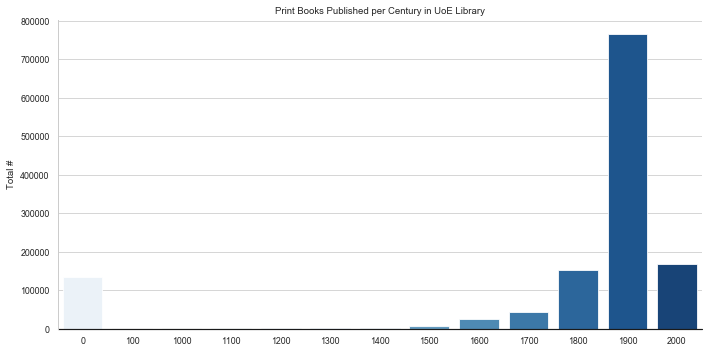

In [31]:
# set up the chart style and matplotlib figure
sns.set(style="whitegrid", context="paper")
f, ax1 = plt.subplots(1, 1, figsize=(10,5), sharex=False)
title1 = "Print Books Published per Century in UoE Library"

# assign the data to plot
x1 = np.array(list(books_per_century['Century']))
y1 = np.array(list(books_per_century['Total #']))
sns.barplot(x=x1, y=y1, palette="Blues", ax=ax1).set_title(title1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Total #")
# ax1.grid(zorder=3)

# draw the chart
sns.despine(bottom=True)
# plt.setp(f.axes)
plt.tight_layout(h_pad=2)

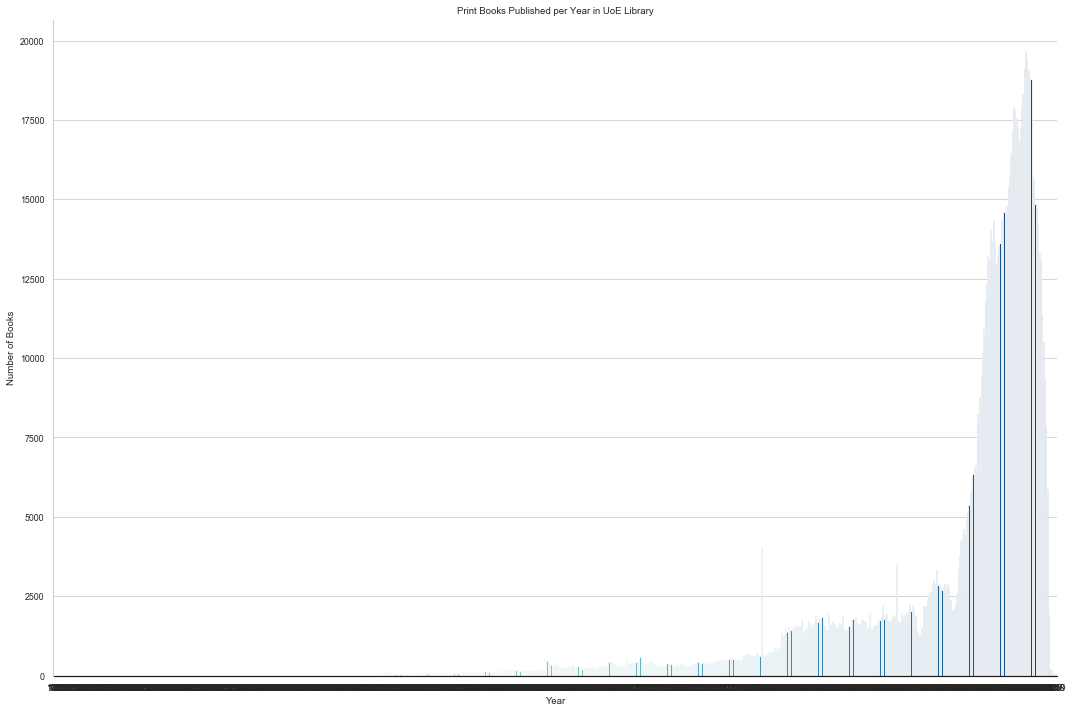

In [32]:
sns.set(style="whitegrid", context="paper")
f, ax1 = plt.subplots(1, 1, figsize=(15,10), sharex=False)
title1 = "Print Books Published per Year in UoE Library"
x = np.array(known_yearly["Publication Year"])
y = np.array(known_yearly["Total Print Books"])
sns.barplot(x=x, y=y, palette="GnBu", ax=ax1).set_title(title1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Number of Books")
ax1.set_xlabel("Year")
# ax1.grid(zorder=3)

# draw the chart
sns.despine(bottom=True)
# plt.setp(f.axes)
plt.tight_layout(h_pad=2)

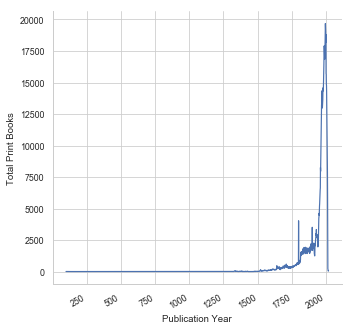

In [33]:
g = sns.relplot(x="Publication Year", y="Total Print Books", kind="line", data=known_yearly)
g.fig.autofmt_xdate()

Export CSV files of book publications grouped by year and century.

In [34]:
yearly.to_csv('Data/VizData/year_publication_timeline.csv')
books_per_century.to_csv('Data/VizData/century_publication_timeline.csv')

## Topical Visualization


Load the CSV file of topic-related MARC fields for print books.

In [2]:
topical = pd.read_csv('Data/VizData/topical_print_book_data.csv')
topical.head()

,Unnamed: 0,lcc_no,lcc_main_class,ddc_no,ddc_main_class,topic_or_geo
0,0,PA3872,LANGUAGE AND LITERATURE,Unknown,Unknown,['Argonauts (Greek mythology)']
1,1,Unknown,MILITARY SCIENCE,Unknown,Unknown,['Hepatitis']
2,2,HB119.F84,SOCIAL SCIENCES,Unknown,Unknown,['Economists']
3,3,HB109.M63,SOCIAL SCIENCES,B,Unknown,['Keynesian economics']
4,4,HB103.K47,SOCIAL SCIENCES,330.156,Social sciences,['Economists']


In [3]:
topical.shape

(1297311, 6)

In [3]:
topical.drop(['Unnamed: 0'], axis=1, inplace=True)
topical.tail()

,lcc_no,lcc_main_class,ddc_no,ddc_main_class,topic_or_geo
1297306,PT2621.A26,LANGUAGE AND LITERATURE,833 .912,Literature,['Unknown']
1297307,NB623.B5,FINE ARTS,730 .92 4,Arts & recreation,['Unknown']
1297308,HF3756.5,SOCIAL SCIENCES,330.9561 01,Social sciences,['Unknown']
1297309,P81.G7,LANGUAGE AND LITERATURE,410 .941,Language,['Language and languages']
1297310,HD47.4,SOCIAL SCIENCES,016.3389 0068,"Computer science, information & general works",['Evaluation research (Social action programs)']


In [4]:
# INPUT:  list of Dewey Decimal Classification (DDC) main class assignments for books
# OUTPUT: a dictionary where keys are DDC main classes and values are the total number of 
#         books assigned to those classes
def countDDC(ddc_main_class_list):
    # Create a dictionary of DDC main classes
    ddc_dict = {'000':'Computer science, information & general works',
                '100':'Philosophy & psychology','200':'Religion','300':'Social sciences',
                '400':'Language','500':'Science','600':'Technology','700':'Arts & recreation',
                '800':'Literature','900':'History & geography'}
    ddc_names = list(ddc_dict.values())
    ddc_counts = dict.fromkeys(ddc_names, 0)
    ddc_counts["Unknown"] = 0

    # Count occurences of main classes in input list
    for name in ddc_main_class_list:
        ddc_counts[name] += 1
    
    return ddc_counts

In [5]:
# INPUT:  list of Library of Congress Classification (LCC) main class assignments for books
# OUTPUT: a dictionary where keys are LCC main classes and values are the total number of 
#         books assigned to those classes
def countLCC(lcc_main_class_list):
    # Create a dictionary of LCC main classes
    lcc_dict = {'A':'GENERAL WORKS','B':'PHILOSOPHY. PSYCHOLOGY. RELIGION','C':'AUXILIARY SCIENCES OF HISTORY',
                'D':'WORLD HISTORY AND HISTORY OF EUROPE, ASIA, AFRICA, AUSTRALIA, NEW ZEALAND, ETC.',
                'E':'HISTORY OF THE AMERICAS','F':'HISTORY OF THE AMERICAS','G':'GEOGRAPHY. ANTHROPOLOGY. RECREATION',
                'H':'SOCIAL SCIENCES','J':'POLITICAL SCIENCE','K':'LAW','L':'EDUCATION','M':'MUSIC AND BOOKS ON MUSIC',
                'N':'FINE ARTS','P':'LANGUAGE AND LITERATURE','Q':'SCIENCE','R':'MEDICINE','S':'AGRICULTURE',
                'T':'TECHNOLOGY','U':'MILITARY SCIENCE','V':'NAVAL SCIENCE','Z':'BIBLIOGRAPHY. LIBRARY SCIENCE. INFORMATION RESOURCES (GENERAL)'}
    lcc_names = list(lcc_dict.values())
    lcc_counts = dict.fromkeys(lcc_names, 0)
    lcc_counts["UNKNOWN"] = 0

    # Count occurences of main classes in input list
    for name in lcc_main_class_list:
        lcc_counts[name] += 1
    
    return lcc_counts

In [6]:
lcc_classes = list(topical['lcc_main_class'])
lcc_counts = countLCC(lcc_classes)

ddc_classes = list(topical['ddc_main_class'])
ddc_counts = countDDC(ddc_classes)

print(lcc_counts)
print()
print(ddc_counts)

{'GENERAL WORKS': 3031, 'PHILOSOPHY. PSYCHOLOGY. RELIGION': 97424, 'AUXILIARY SCIENCES OF HISTORY': 5964, 'WORLD HISTORY AND HISTORY OF EUROPE, ASIA, AFRICA, AUSTRALIA, NEW ZEALAND, ETC.': 76773, 'HISTORY OF THE AMERICAS': 16276, 'GEOGRAPHY. ANTHROPOLOGY. RECREATION': 21987, 'SOCIAL SCIENCES': 92155, 'POLITICAL SCIENCE': 19881, 'LAW': 33801, 'EDUCATION': 18559, 'MUSIC AND BOOKS ON MUSIC': 20499, 'FINE ARTS': 67628, 'LANGUAGE AND LITERATURE': 158063, 'SCIENCE': 64909, 'MEDICINE': 23035, 'AGRICULTURE': 10652, 'TECHNOLOGY': 25622, 'MILITARY SCIENCE': 528372, 'NAVAL SCIENCE': 578, 'BIBLIOGRAPHY. LIBRARY SCIENCE. INFORMATION RESOURCES (GENERAL)': 11437, 'UNKNOWN': 665}

{'Computer science, information & general works': 12408, 'Philosophy & psychology': 16793, 'Religion': 27410, 'Social sciences': 105145, 'Language': 11433, 'Science': 30318, 'Technology': 37367, 'Arts & recreation': 58644, 'Literature': 56712, 'History & geography': 41167, 'Unknown': 899914}


In [7]:
df_lcc = pd.DataFrame()
df_lcc['LCC Main Class'] = lcc_counts.keys()
df_lcc['Total Print Books'] = lcc_counts.values()
df_lcc

,LCC Main Class,Total Print Books
0,GENERAL WORKS,3031
1,PHILOSOPHY. PSYCHOLOGY. RELIGION,97424
2,AUXILIARY SCIENCES OF HISTORY,5964
3,"WORLD HISTORY AND HISTORY OF EUROPE, ASIA, AFR...",76773
4,HISTORY OF THE AMERICAS,16276
5,GEOGRAPHY. ANTHROPOLOGY. RECREATION,21987
6,SOCIAL SCIENCES,92155
7,POLITICAL SCIENCE,19881
8,LAW,33801
9,EDUCATION,18559


In [8]:
df_ddc = pd.DataFrame()
df_ddc['DDC Main Class'] = ddc_counts.keys()
df_ddc['Total Print Books'] = ddc_counts.values()
df_ddc

,DDC Main Class,Total Print Books
0,"Computer science, information & general works",12408
1,Philosophy & psychology,16793
2,Religion,27410
3,Social sciences,105145
4,Language,11433
5,Science,30318
6,Technology,37367
7,Arts & recreation,58644
8,Literature,56712
9,History & geography,41167


Plot the classification data on bar charts, one for the Library of Congress Classification system and one for the Dewey Decimal Classification System

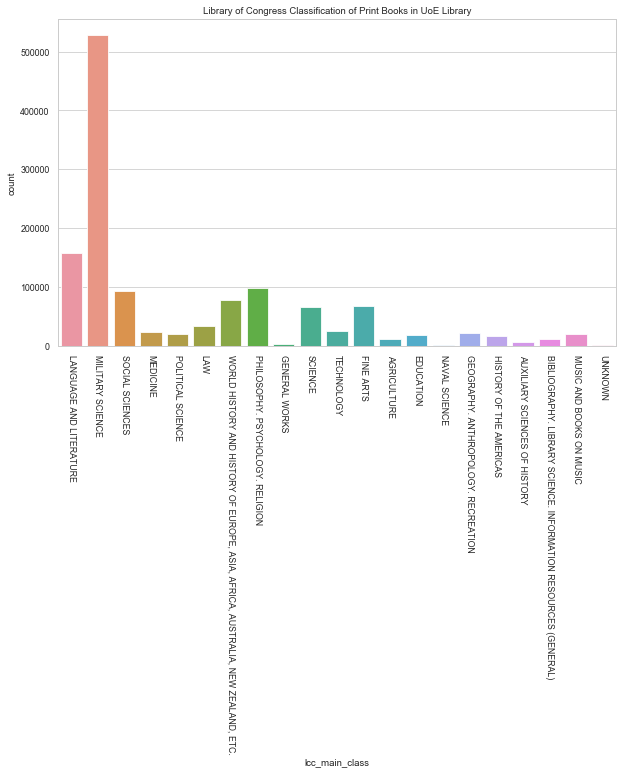

In [31]:
title1 = "Library of Congress Classification of Print Books in UoE Library"
plt.figure(figsize=(10,6))
sns.countplot(x="lcc_main_class", data=topical)
plt.xticks(rotation=-90)
plt.title(title1)

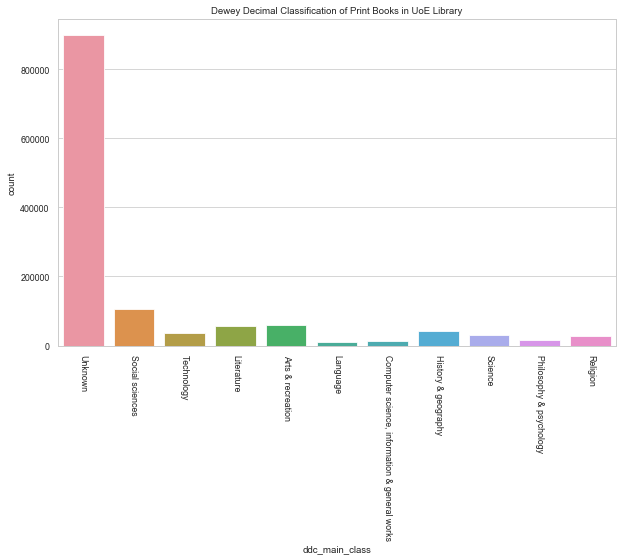

In [25]:
title2 = "Dewey Decimal Classification of Print Books in UoE Library"
plt.figure(figsize=(10,6))
sns.countplot(x="ddc_main_class", data=topical)  #.set_title(title2)
plt.xticks(rotation=-90)
plt.title(title2)

Explore the overlap between DDC and LCC classifications of print books.

In [9]:
gen = topical[(topical['lcc_main_class'] == 'GENERAL WORKS') | (topical['ddc_main_class'] == 'Computer science, information & general works')]
gen_both = topical[(topical['lcc_main_class'] == 'GENERAL WORKS') & (topical['ddc_main_class'] == 'Computer science, information & general works')]
print("Either general:",gen.shape[0])
print("Both general:",gen_both.shape[0])

# GENERAL WORKS: 3031
# Computer Sc...: 12408

Either general: 14994
Both general: 445


In [10]:
cs1 = topical[(topical['lcc_main_class'] == 'TECHNOLOGY') | (topical['ddc_main_class'] == 'Computer science, information & general works')]
cs1_both = topical[(topical['lcc_main_class'] == 'TECHNOLOGY') & (topical['ddc_main_class'] == 'Computer science, information & general works')]
print("Either Tech or CS:",cs1.shape[0])
print("Both Tech and CS:",cs1_both.shape[0],"(",(cs1_both.shape[0]/cs1.shape[0])*100,"% )")

# TECHNOLOGY: 25622
# Computer Sc...: 12408

Either Tech or CS: 37440
Both Tech and CS: 590 ( 1.5758547008547008 % )


In [11]:
cs2 = topical[(topical['lcc_main_class'] == 'BIBLIOGRAPHY. LIBRARY SCIENCE. INFORMATION RESOURCES (GENERAL)') | (topical['ddc_main_class'] == 'Computer science, information & general works')]
cs2_both = topical[(topical['lcc_main_class'] == 'BIBLIOGRAPHY. LIBRARY SCIENCE. INFORMATION RESOURCES (GENERAL)') & (topical['ddc_main_class'] == 'Computer science, information & general works')]
print("Either Bib/Lib/Inf or CS:", cs2.shape[0])
print("Both Bib/Lib/Inf and CS:",cs2_both.shape[0],"(",(cs2_both.shape[0]/cs2.shape[0])*100,"% )")

# BIBLIOGRAPHY..: 11437
# Computer Sc...: 12408

Either Bib/Lib/Inf or CS: 20120
Both Bib/Lib/Inf and CS: 3725 ( 18.513916500994036 % )


In [78]:
tech = topical[(topical['lcc_main_class'] == 'TECHNOLOGY') | (topical['ddc_main_class'] == 'Technology')]
tech_both = topical[(topical['lcc_main_class'] == 'TECHNOLOGY') & (topical['ddc_main_class'] == 'Technology')]
print("Either technology:", tech.shape[0])
print("Both technology:",tech_both.shape[0],"(",(tech_both.shape[0]/tech.shape[0])*100,"% )")

# TECHNOLOGY: 25622
# Technology: 37367

Either technology: 54608
Both technology: 8381 ( 15.347568121886903 % )


In [15]:
unk = topical[((topical['lcc_main_class'] == 'UNKNOWN') & (topical['ddc_main_class'] != 'Unknown')) | ((topical['lcc_main_class'] != 'UNKNOWN') & (topical['ddc_main_class'] == 'Unknown'))]
unk_both = topical[(topical['lcc_main_class'] == 'UNKNOWN') & (topical['ddc_main_class'] == 'Unknown')]
print("Either unknown:", unk.shape[0])
print("Both unknown:",unk_both.shape[0],"(",(unk_both.shape[0]/unk.shape[0])*100,"% )")

# UNKNOWN: 665
# Unknown: 899914

print()

print("Books with at least one call number:",(topical.shape[0])-(unk_both.shape[0]), "(", (((topical.shape[0])-(unk_both.shape[0]))/topical.shape[0])*100,")")
print("Books with one call number:",(unk.shape[0]),"(",((unk.shape[0])/topical.shape[0])*100,")")

known_both = topical[(topical['lcc_main_class'] != 'UNKNOWN') & (topical['ddc_main_class'] != 'Unknown')]
print("Books with two call numbers:",(known_both.shape[0]), "(", (known_both.shape[0]/topical.shape[0])*100 ,")")

print()

lcc_u = topical[topical['lcc_main_class'] == 'UNKNOWN']
lcc_k = topical[topical['lcc_main_class'] != 'UNKNOWN']
ddc_u = topical[topical['ddc_main_class'] == 'Unknown']
ddc_k = topical[topical['ddc_main_class'] != 'Unknown']
print("Without LCC:",lcc_u.shape[0], "(", (lcc_u.shape[0]/topical.shape[0])*100 ,"%)")
print("With LCC:",lcc_k.shape[0], "(", (lcc_k.shape[0]/topical.shape[0])*100 ,"%)")
print("Without DDC:",ddc_u.shape[0], "(", (ddc_u.shape[0]/topical.shape[0])*100 ,"%)")
print("With DDC:",ddc_k.shape[0], "(", (ddc_k.shape[0]/topical.shape[0])*100 ,"%)")

Either unknown: 899591
Both unknown: 494 ( 0.05491384418029971 % )

Books with at least one call number: 1296817 ( 99.96192123554029 )
Books with one call number: 899591 ( 69.3427404839703 )
Books with two call numbers: 397226 ( 30.61918075156998 )

Without LCC: 665 ( 0.0512598752342345 %)
With LCC: 1296646 ( 99.94874012476576 %)
Without DDC: 899914 ( 69.3676381376555 %)
With DDC: 397397 ( 30.6323618623445 %)


In [81]:
sci = topical[(topical['lcc_main_class'] == 'SCIENCE') | (topical['ddc_main_class'] == 'Science')]
sci_both = topical[(topical['lcc_main_class'] == 'SCIENCE') & (topical['ddc_main_class'] == 'Science')]
print("Either science:",sci.shape[0])
print("Both science:",sci_both.shape[0],"(",(sci_both.shape[0]/sci.shape[0])*100,"% )")

Either science: 69598
Both science: 25629 ( 36.82433403258714 % )


In [87]:
lang = topical[(topical['lcc_main_class'] == 'LANGUAGE AND LITERATURE') | (topical['ddc_main_class'] == 'Language')]
lang_both = topical[(topical['lcc_main_class'] == 'LANGUAGE AND LITERATURE') & (topical['ddc_main_class'] == 'Language')]
print("Either language:",lang.shape[0])
print("Both language:",lang_both.shape[0],"(",(lang_both.shape[0]/lang.shape[0])*100,"% )")

print()

lit = topical[(topical['lcc_main_class'] == 'LANGUAGE AND LITERATURE') | (topical['ddc_main_class'] == 'Literature')]
lit_both = topical[(topical['lcc_main_class'] == 'LANGUAGE AND LITERATURE') & (topical['ddc_main_class'] == 'Literature')]
print("Either literature:",lit.shape[0])
print("Both literature:",lit_both.shape[0],"(",(lit_both.shape[0]/lit.shape[0])*100,"% )")

print()

litlang = topical[(topical['lcc_main_class'] == 'LANGUAGE AND LITERATURE') | ((topical['ddc_main_class'] == 'Literature') | (topical['ddc_main_class'] == 'Language'))]
litlang_both = topical[(topical['lcc_main_class'] == 'LANGUAGE AND LITERATURE') & ((topical['ddc_main_class'] == 'Literature') | (topical['ddc_main_class'] == 'Language'))]
print("Either language or literature:",litlang.shape[0])
print("Both language and literature:",litlang_both.shape[0],"(",(litlang_both.shape[0]/litlang.shape[0])*100,"% )")

Either language: 159743
Both language: 9753 ( 6.105431849908916 % )

Either literature: 165571
Both literature: 49204 ( 29.717764584377697 % )

Either language or literature: 167251
Both language and literature: 58957 ( 35.25061135658382 % )


In [89]:
rel = topical[(topical['lcc_main_class'] == 'PHILOSOPHY. PSYCHOLOGY. RELIGION') | (topical['ddc_main_class'] == 'Religion')]
rel_both = topical[(topical['lcc_main_class'] == 'PHILOSOPHY. PSYCHOLOGY. RELIGION') & (topical['ddc_main_class'] == 'Religion')]
print("Either religion:",rel.shape[0])
print("Both language:",rel_both.shape[0],"(",(rel_both.shape[0]/rel.shape[0])*100,"% )")

print()

pp = topical[(topical['lcc_main_class'] == 'PHILOSOPHY. PSYCHOLOGY. RELIGION') | (topical['ddc_main_class'] == 'Philosophy & psychology')]
pp_both = topical[(topical['lcc_main_class'] == 'PHILOSOPHY. PSYCHOLOGY. RELIGION') & (topical['ddc_main_class'] == 'Philosophy & psychology')]
print("Either phil/psych:",pp.shape[0])
print("Both phil/psych:",pp_both.shape[0],"(",(pp_both.shape[0]/pp.shape[0])*100,"% )")

print()

relpp = topical[(topical['lcc_main_class'] == 'PHILOSOPHY. PSYCHOLOGY. RELIGION') | ((topical['ddc_main_class'] == 'Philosophy & psychology') | (topical['ddc_main_class'] == 'Religion'))]
relpp_both = topical[(topical['lcc_main_class'] == 'PHILOSOPHY. PSYCHOLOGY. RELIGION') & ((topical['ddc_main_class'] == 'Philosophy & psychology') | (topical['ddc_main_class'] == 'Religion'))]
print("Either rel/phil/psych:",relpp.shape[0])
print("Both rel/phil/psych:",relpp_both.shape[0],"(",(relpp_both.shape[0]/relpp.shape[0])*100,"% )")

Either religion: 100778
Both language: 24056 ( 23.870289150409814 % )

Either phil/psych: 101182
Both phil/psych: 13035 ( 12.882726176592673 % )

Either rel/phil/psych: 104536
Both rel/phil/psych: 37091 ( 35.48155659294406 % )


In [91]:
ss = topical[(topical['lcc_main_class'] == 'SOCIAL SCIENCES') | (topical['ddc_main_class'] == 'Social sciences')]
ss_both = topical[(topical['lcc_main_class'] == 'SOCIAL SCIENCES') & (topical['ddc_main_class'] == 'Social sciences')]
print("Either social sciences:",ss.shape[0])
print("Both social sciences:",ss_both.shape[0],"(",(ss_both.shape[0]/ss.shape[0])*100,"% )")

Either social sciences: 157608
Both social sciences: 39692 ( 25.184000812141516 % )


In [96]:
art = topical[(topical['lcc_main_class'] == 'FINE ARTS') | (topical['ddc_main_class'] == 'Arts & recreation')]
art_both = topical[(topical['lcc_main_class'] == 'FINE ARTS') & (topical['ddc_main_class'] == 'Arts & recreation')]
print("Either arts:",art.shape[0])
print("Both arts:",art_both.shape[0],"(",(art_both.shape[0]/art.shape[0])*100,"% )")

Either arts: 95360
Both arts: 30912 ( 32.41610738255034 % )


In [95]:
artmusic = topical[((topical['lcc_main_class'] == 'FINE ARTS') | (topical['lcc_main_class'] == 'MUSIC AND BOOKS ON MUSIC')) | (topical['ddc_main_class'] == 'Arts & recreation')]
artmusic_both = topical[((topical['lcc_main_class'] == 'FINE ARTS') | (topical['lcc_main_class'] == 'MUSIC AND BOOKS ON MUSIC')) & (topical['ddc_main_class'] == 'Arts & recreation')]
print("Either arts/music:",artmusic.shape[0])
print("Both arts/music:",artmusic_both.shape[0],"(",(artmusic_both.shape[0]/artmusic.shape[0])*100,"% )")

Either arts/music: 108649
Both arts/music: 38122 ( 35.087299468932066 % )


In [100]:
his = topical[((topical['lcc_main_class'] == 'AUXILIARY SCIENCES OF HISTORY') | (topical['lcc_main_class'] == 'WORLD HISTORY AND HISTORY OF EUROPE, ASIA, AFRICA, AUSTRALIA, NEW ZEALAND, ETC.') | (topical['lcc_main_class'] == 'HISTORY OF THE AMERICAS') | (topical['lcc_main_class'] == 'GEOGRAPHY. ANTHROPOLOGY. RECREATION')) | (topical['ddc_main_class'] == 'History & geography')]
his_both = topical[((topical['lcc_main_class'] == 'AUXILIARY SCIENCES OF HISTORY') | (topical['lcc_main_class'] == 'WORLD HISTORY AND HISTORY OF EUROPE, ASIA, AFRICA, AUSTRALIA, NEW ZEALAND, ETC.') | (topical['lcc_main_class'] == 'HISTORY OF THE AMERICAS') | (topical['lcc_main_class'] == 'GEOGRAPHY. ANTHROPOLOGY. RECREATION')) & (topical['ddc_main_class'] == 'History & geography')]
print("Either histories:",his.shape[0])
print("Both histories:",his_both.shape[0],"(",(his_both.shape[0]/his.shape[0])*100,"% )")

Either histories: 128857
Both histories: 33310 ( 25.85036125317212 % )
